In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
%matplotlib inline

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.Flowers102(root = "data", transform = transform, download = True, split = "test")
test_data = datasets.Flowers102(root = "data", transform = transform, download = True, split = "train")

100%|██████████| 344862509/344862509 [00:21<00:00, 16037770.72it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1556201.48it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15300175.87it/s]


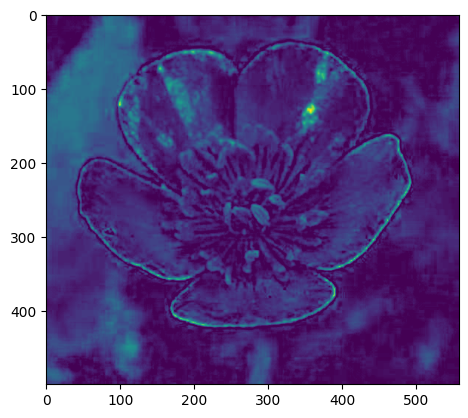

In [ ]:
for i in range(3):
  plt.imshow(train_data[2117][0][i])

In [ ]:
train_data[2117][0].shape

torch.Size([3, 500, 558])

In [ ]:
new_train_data : list = []

for i in range(len(train_data)):
  new_train_data.append(np.array([cv2.resize(train_data[i][0].detach().numpy().transpose((1, 2, 0)), (50, 65)).transpose((2, 0, 1)), train_data[i][-1]]))

<ipython-input-6-06e98ea43c8a>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_train_data.append(np.array([cv2.resize(train_data[i][0].detach().numpy().transpose((1, 2, 0)), (50, 65)).transpose((2, 0, 1)), train_data[i][-1]]))


In [ ]:
new_test_data : list = []

for i in range(len(test_data)):
  new_test_data.append(np.array([cv2.resize(test_data[i][0].detach().numpy().transpose((1, 2, 0)), (50, 65)).transpose((2, 0, 1)), test_data[i][-1]]))

<ipython-input-7-6b47c40d6844>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_test_data.append(np.array([cv2.resize(test_data[i][0].detach().numpy().transpose((1, 2, 0)), (50, 65)).transpose((2, 0, 1)), test_data[i][-1]]))


In [ ]:
train_loader = DataLoader(new_train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(new_test_data, batch_size = 10, shuffle = True)

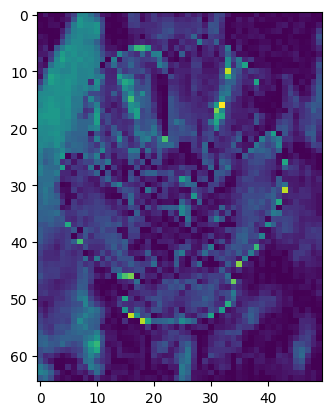

In [ ]:
for i in range(3):
  plt.imshow(train_loader.dataset[2117][0][i])

In [ ]:
train_loader.dataset[2117][-1]

47

In [ ]:
torch.manual_seed(41)

In [ ]:
conv1 = nn.Conv2d(3, 10, 5, 1)
conv2 = nn.Conv2d(10, 20, 3, 1)

X = F.relu(conv1(torch.tensor(train_loader.dataset[2117][0])))
X = F.avg_pool2d(X, 1, 2)
X = F.relu(conv2(X))

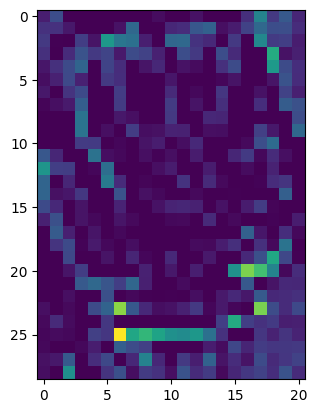

In [ ]:
for i in range(20):
  plt.imshow(X.detach().numpy()[i])

In [ ]:
X.shape

torch.Size([20, 29, 21])

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 10, 5, 1)
    self.conv2 = nn.Conv2d(10, 20, 3, 1)

    self.fc1 = nn.Linear(20 * 29 * 21, 210)
    self.fc2 = nn.Linear(210, 84)
    self.fc3 = nn.Linear(84, train_loader.dataset[len(train_loader.dataset) - 1][-1] + 1)

  def feedForward(self, X):
    X = F.relu(conv1(torch.tensor(train_loader.dataset[2117][0])))
    X = F.avg_pool2d(X, 1, 2)
    X = F.relu(conv2(X))

    X = X.view(-1, 20 * 29 * 21)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim = 1)

In [ ]:
model = CNN()

In [ ]:
model

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12180, out_features=210, bias=True)
  (fc2): Linear(in_features=210, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=102, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
import time

start_time = time.time()

# Variables To Track.......
epochs : int = 2
train_losses : list = []
test_losses : list = []
train_correct : list = []
test_correct : list = []

i : int = 1
while i <= epochs:
  train_corr : int = 0
  test_corr : int = 0

  #Training
  for b, (X_train, y_train) in enumerate(train_loader.dataset[:]):
    b += 1
    y_pred = model.feedForward(X_train)
    loss = criterion(y_pred, torch.LongTensor([y_train]))

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr : int = (predicted == y_train).sum()
    train_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b + 1) % 100 == 0:
      print(f"Epoch : {i}, Batch : {b + 1}, Loss : {loss.item()}")

  train_losses.append(loss)
  train_correct.append(train_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader.dataset[:]):
      y_val = model.feedForward(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, torch.LongTensor([y_test]))
  test_losses.append(loss)
  test_correct.append(test_corr)

  i += 1

current_time = time.time()
print(f"Training took {current_time - start_time} seconds!")

Epoch : 1, Batch : 100, Loss : 4.478611946105957
Epoch : 1, Batch : 200, Loss : 4.665312767028809
Epoch : 1, Batch : 300, Loss : 4.680973529815674
Epoch : 1, Batch : 400, Loss : 4.3015899658203125
Epoch : 1, Batch : 500, Loss : 4.611021995544434
Epoch : 1, Batch : 600, Loss : 4.2861456871032715
Epoch : 1, Batch : 700, Loss : 4.153614044189453
Epoch : 1, Batch : 800, Loss : 4.545901298522949
Epoch : 1, Batch : 900, Loss : 4.821694374084473
Epoch : 1, Batch : 1000, Loss : 4.440162658691406
Epoch : 1, Batch : 1100, Loss : 4.347499847412109
Epoch : 1, Batch : 1200, Loss : 4.922677516937256
Epoch : 1, Batch : 1300, Loss : 4.403881072998047
Epoch : 1, Batch : 1400, Loss : 4.066893100738525
Epoch : 1, Batch : 1500, Loss : 4.579631805419922
Epoch : 1, Batch : 1600, Loss : 3.9959137439727783
Epoch : 1, Batch : 1700, Loss : 4.224729537963867
Epoch : 1, Batch : 1800, Loss : 4.501767158508301
Epoch : 1, Batch : 1900, Loss : 4.061572074890137
Epoch : 1, Batch : 2000, Loss : 3.694211006164551
Epoch 

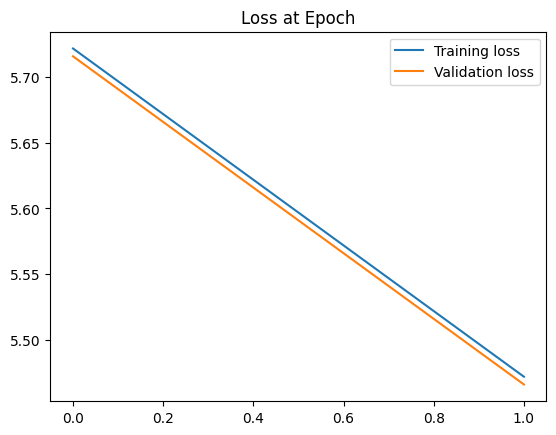

In [ ]:
# plotting the results
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.title("Loss at Epoch")
plt.legend()

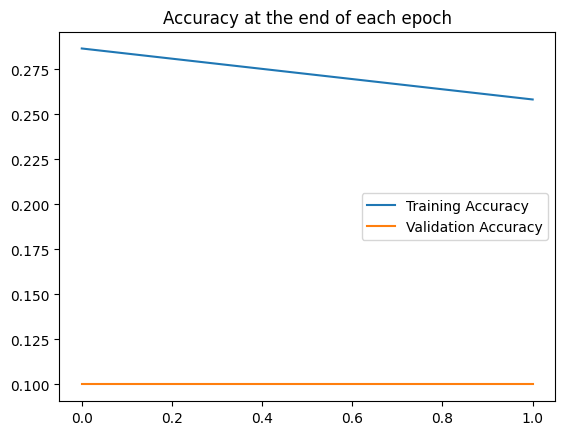

In [ ]:
plt.plot([t / 600 for t in train_correct], label = "Training Accuracy")
plt.plot([t / 100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader.dataset[:]:
    y_pred = model.feedForward(X_test)
    predicted = torch.max(y_pred, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
# Accuracy
print(f"Accuracy : {correct.item() / len(test_data) * 100}%")

Accuracy : 0.9803921568627451%


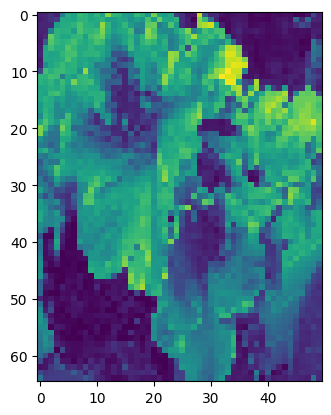

In [ ]:
for i in range(3):
  plt.imshow(test_loader.dataset[717][0][i])

In [ ]:
model.eval()
with torch.no_grad():
  prediction = model.feedForward(test_loader.dataset[717][0])

In [ ]:
print(f"Prediction : {prediction.argmax()}")

Prediction : 76


In [ ]:
torch.save(model.state_dict(), "Flower102_CNN_Model.pt")